# Необходимо предсказывать пол клиента, основываясь на его транзакционных исторических данных. 


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier


%matplotlib inline
filterwarnings('ignore')

C:\Python\Python36\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
ipykernel_launcher:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [ ]:
# читаем данные
tr_mcc_codes = pd.read_csv('data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('data/transactions.csv', index_col='customer_id')
transactions.join(tr_mcc_codes, how='inner')
gender_train = pd.read_csv('data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')


del transactions

In [20]:
transactions_train

,tr_datetime,mcc_code,tr_type,amount,term_id,gender
customer_id,,,,,,
22899,1 15:26:45,4814,1030,-4491.83,NaN,1
22899,2 20:52:48,4814,1030,-2245.92,NaN,1
22899,5 18:52:19,6011,2010,-44918.32,NaN,1
22899,6 12:28:22,6011,2010,-150476.36,NaN,1
22899,28 10:41:01,6010,7030,33688.74,NaN,1
...,...,...,...,...,...,...
99999680,444 00:00:00,5411,1110,-5659.71,31190432,1
99999680,444 00:00:00,6011,2110,-134754.95,406826,1
99999680,446 00:00:00,5541,1110,-11229.58,J038003,1


In [3]:
# Функции для классификатора 
# оценки его результатов и построение прогноза на тестах


def cv_score(params, train, y_true):
    '''
    Cross-validation score
    (среднее значение метрики ROC AUC на тренировочных данных)
    '''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))


def fit_predict(params, num_trees, train, test, target):
    '''
    Построение модели + возврат результатов классификации тестовых пользователей
    '''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission


def draw_feature_importances(clf, top_k=10):
    '''
    Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
    в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [4]:
def fit_predict_SVC(train, test, target):
    params['learning_rate'] = params['eta']
    svc=SVC(probability=True, kernel='linear')
    abc = AdaBoostClassifier(base_estimator=svc, n_estimators=50, learning_rate=1)
    model = abc.fit(train.fillna(0).to_numpy(dtype='float64'), target)
    
    y_pred = model.predict(test)
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

In [5]:
def cv_score_model(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=50, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели

In [52]:
params = {
    'scale_pos_weight':1,
    'seed':26,
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.6,
    'colsample_bytree': 0.7,
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 1,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [8]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


In [173]:
alg_ngbh = KNeighborsClassifier(n_neighbors=131, n_jobs=-1)
scores = cross_val_score(alg_ngbh, data_train.fillna(0).to_numpy(dtype='float32'), target, cv=cv, n_jobs=-1)
alg_ngbh.fit(data_train.fillna(0).to_numpy(dtype='float32'), target)
knn_res = alg_ngbh.predict_proba(data_train.fillna(0).to_numpy(dtype='float32'))

param_grid = {'n_neighbors':np.arange(1,150)}
knn_cv= GridSearchCV(alg_ngbh,param_grid,cv=5)
knn_cv.fit(data_train.fillna(0).to_numpy(dtype='float32'), target)
print(knn_cv.best_score_, knn_cv.best_params_)

0.5935714285714285 {'n_neighbors': 44}


In [53]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

[10:28:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:28:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:28:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

In [55]:
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 113, data_train, data_test, target)

[10:42:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [56]:
submission.to_csv('data/новыйфайл.csv')

Добавим дополнительные переменные по каждому пользователю в модель.
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий.

In [9]:
import datetime as dt
def day_to_month(day):
    return str((dt.datetime(2000, 1, 1) + dt.timedelta(int(day) - 1)).month)

In [10]:
day_to_month(100)

'4'

In [25]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)
    df['month'] = df['tr_datetime'].str.split().apply(lambda x: day_to_month(int(x[0])))

In [38]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mmc_')))
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['month'].value_counts(normalize=True).add_prefix('month_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['max', 'mean', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['max', 'mean', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    
    for month in range(1,13):
        features.append(pd.Series(x[(x['amount']<0) & (x['month']==month)]['amount'].agg(['sum','median'])\
                                                        .add_prefix(str(month)+'negative_transactions_in'+'_')))
    #features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    return pd.concat(features)

In [39]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

In [40]:
target = data_train.join(gender_train, how='inner')['gender']

In [41]:
cv_score(params, data_train, target)

[10:03:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:03:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:03:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 

In [42]:
### Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 524, data_train, data_test, target)

[10:05:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




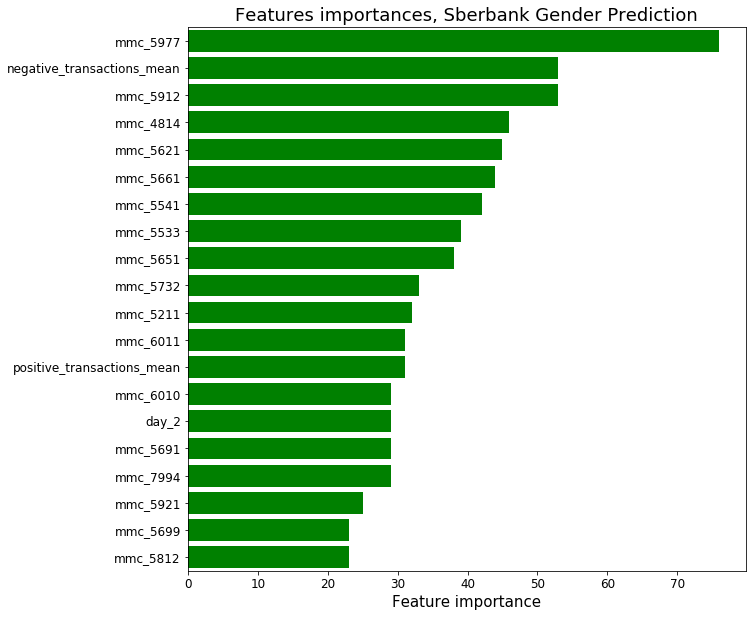

In [43]:
draw_feature_importances(clf, 20)

In [44]:
submission.to_csv('data/secondtry.csv')


In [45]:
def modelfit(alg, X, y,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
    
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
                    
    return alg

In [46]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0.0,
    subsample=0.6,
    colsample_bytree=0.7,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=26)
    
alg = modelfit(xgb1, data_train, target)

[0]	train-auc:0.78529+0.00355	test-auc:0.75130+0.00649
[1]	train-auc:0.82047+0.00388	test-auc:0.77646+0.01075
[2]	train-auc:0.83562+0.00407	test-auc:0.79170+0.00689
[3]	train-auc:0.84577+0.00353	test-auc:0.79906+0.00874
[4]	train-auc:0.85447+0.00290	test-auc:0.80790+0.01007
[5]	train-auc:0.86037+0.00290	test-auc:0.81384+0.00900
[6]	train-auc:0.86486+0.00286	test-auc:0.81805+0.00849
[7]	train-auc:0.86904+0.00239	test-auc:0.82004+0.00865
[8]	train-auc:0.87271+0.00212	test-auc:0.82286+0.00911
[9]	train-auc:0.87584+0.00174	test-auc:0.82580+0.00912
[10]	train-auc:0.87853+0.00155	test-auc:0.82828+0.00824
[11]	train-auc:0.88122+0.00209	test-auc:0.83059+0.00845
[12]	train-auc:0.88454+0.00262	test-auc:0.83184+0.00918
[13]	train-auc:0.88738+0.00221	test-auc:0.83351+0.00960
[14]	train-auc:0.89023+0.00277	test-auc:0.83604+0.00930
[15]	train-auc:0.89243+0.00286	test-auc:0.83687+0.00887
[16]	train-auc:0.89502+0.00230	test-auc:0.83754+0.00860
[17]	train-auc:0.89704+0.00190	test-auc:0.83846+0.00828
[1

[146]	train-auc:0.98773+0.00119	test-auc:0.87265+0.00517
[147]	train-auc:0.98791+0.00119	test-auc:0.87267+0.00514
[148]	train-auc:0.98809+0.00123	test-auc:0.87272+0.00538
[149]	train-auc:0.98827+0.00118	test-auc:0.87252+0.00521
[150]	train-auc:0.98849+0.00124	test-auc:0.87273+0.00515
[151]	train-auc:0.98862+0.00125	test-auc:0.87280+0.00503
[152]	train-auc:0.98881+0.00113	test-auc:0.87285+0.00514
[153]	train-auc:0.98902+0.00117	test-auc:0.87277+0.00509
[154]	train-auc:0.98917+0.00112	test-auc:0.87278+0.00518
[155]	train-auc:0.98927+0.00109	test-auc:0.87282+0.00528
[156]	train-auc:0.98948+0.00117	test-auc:0.87287+0.00537
[157]	train-auc:0.98962+0.00120	test-auc:0.87295+0.00540
[158]	train-auc:0.98987+0.00116	test-auc:0.87287+0.00550
[159]	train-auc:0.99006+0.00114	test-auc:0.87279+0.00555
[160]	train-auc:0.99027+0.00115	test-auc:0.87286+0.00546
[161]	train-auc:0.99045+0.00118	test-auc:0.87301+0.00528
[162]	train-auc:0.99060+0.00118	test-auc:0.87305+0.00516
[163]	train-auc:0.99086+0.00114

In [54]:
param_test1 = {
 'max_depth': range(2,10,2),
 'min_child_weight': range(1,7,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=142, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
gsearch1.fit(data_train, target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=None, max_depth=5,
       min_child_weight=1,...weight=1, seed=27, subsample=0.8,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': range(2, 10, 2), 'min_child_weight': range(1, 7, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### gsearch1.best_params_, gsearch1.best_score_

In [128]:
param_test3 = {
    'gamma':np.linspace(0.09, 0.11, 11)
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=142, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(data_train, target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=None, max_depth=4,
       min_child_weight=6,...weight=1, seed=27, subsample=0.8,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': array([0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
       0.108, 0.11 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [125]:
gsearch3.best_params_, gsearch3.best_score_#, gsearch3.cv_results_


({'gamma': 0.09222222222222222}, 0.6140758903386234)

In [126]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(data_train, target)
gsearch4.best_params_, gsearch4.best_score_


({'colsample_bytree': 0.6, 'subsample': 0.7}, 0.6133431335502468)

In [305]:
for key in data_train.keys(): print(key)

0
day_0
day_1
day_2
day_3
day_4
day_5
day_6
hour_0
hour_1
hour_10
hour_11
hour_12
hour_13
hour_14
hour_15
hour_16
hour_17
hour_18
hour_19
hour_2
hour_20
hour_21
hour_22
hour_23
hour_3
hour_4
hour_5
hour_6
hour_7
hour_8
hour_9
month_1
month_10
month_11
month_12
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
negative_transactions_count
negative_transactions_in10_count
negative_transactions_in10_mean
negative_transactions_in10_std
negative_transactions_in10_sum
negative_transactions_in11_count
negative_transactions_in11_mean
negative_transactions_in11_std
negative_transactions_in11_sum
negative_transactions_in12_count
negative_transactions_in12_mean
negative_transactions_in12_std
negative_transactions_in12_sum
negative_transactions_in1_count
negative_transactions_in1_mean
negative_transactions_in1_std
negative_transactions_in1_sum
negative_transactions_in2_count
negative_transactions_in2_mean
negative_transactions_in2_std
negative_transactions_in2_sum
negative_transaction

In [297]:
int(transactions_train.iloc[10][0].split()[0])

61

In [309]:
del data_test, data_train

In [57]:
sum(range(101))

5050

In [58]:
def func(X):
    return [x**3 - 6 * x ** 2 + 11 * x - 6 for x in X]
func([1,2,3])

[0, 0, 0]

In [59]:
123456789 % 3

0

In [60]:
169/13

13.0

In [64]:
(57.80 - 30)*10e5

27799999.999999996